# 🔍 Multimodal Contrastive Representation Learning

In this lab, you'll build and analyze a compact **multimodal contrastive representation learning** system that aligns images with text embeddings. The goal is to understand how contrastive objectives can produce a shared embedding space across modalities.

You will:

- **Prepare** a filtered CIFAR-100 dataset and use a frozen **MobileNetV3 encoder** with a small trainable projection head.  
- **Train** the model using a symmetric contrastive (InfoNCE) loss to associate each image with its corresponding class word.  
- **Evaluate** the learned space through per-class similarity statistics, retrieval performance, confusion matrices, and embedding visualizations.  
- **Test generalization** by applying the model to out-of-distribution (OOD) images.  
- **Interpret** the structure and behaviour of the multimodal embedding space.


In [1]:
# NOTE SET UP

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='.*OpenSSL.*')

import os
import sys
import torch
import torch.nn.functional as F

# Ensure we import from the correct directory (Q6, not AI__Code)
Q6_PATH = '/Users/voodoo/Documents/Artificial Intelligence/Q6'
if Q6_PATH not in sys.path:
    sys.path.insert(0, Q6_PATH)

# Importing text processing, analysis, and data utilities from previous labs.
# (lab2: text_network, lab6: text prep/analysis, lab7: text/image prep/analysis)
from lab2 import process_text_network
from lab6 import prepare_visual_genome_text, filter_punctuation_from_network, analyze_embeddings, find_similar_words
from lab7 import create_mappings, compute_embedding_stats, get_cifar100_vocabulary, analyze_vocabulary_overlap, run_sanity_checks

# Importing all core components for the multimodal training pipeline and
# evaluation from the main script (lab8).
import importlib
import lab8
importlib.reload(lab8)  # Force reload to get the fixed version

from lab8 import (
    CIFAR100Filtered,
    ImageEncoder,
    filter_dataset_indices,
    create_data_splits,
    create_dataloaders,
    train_with_early_stopping,
    run_epoch,
    collect_embeddings,
    print_analysis_results,
    create_visualizations,
    print_example_retrievals,
    process_ood_images,
    compute_alignment_metrics,
    print_final_report
)

device = torch.device("mps")
print(f"Using device: {device} (Apple Silicon GPU)")


MODEL_PATH = 'EMB32_NG10_CS2_BS64.pth'
checkpoint = torch.load(MODEL_PATH, map_location='cpu')

nodes = checkpoint['nodes']
vocab_size = checkpoint['vocab_size']
embedding_dim = checkpoint['embedding_dim']

# Get embeddings directly from state_dict
embeddings = checkpoint['model_state_dict']['center_embeddings.weight'].numpy()

# Create word-index mappings
word_to_idx, idx_to_word = create_mappings(nodes)

print(f"✓ Loaded {vocab_size} word embeddings (dim={embedding_dim})")
print(f"  Sample words: {nodes[:5]}")

cifar_vocab = get_cifar100_vocabulary()
missing_cifar_words = analyze_vocabulary_overlap(cifar_vocab, nodes)
n_train_classes = len(cifar_vocab) - len(missing_cifar_words)

print(f"\nSummary of Vocabulary Overlap:")
print(f"  Total CIFAR-100 Classes: {len(cifar_vocab)}")
print(f"  Classes available in VG vocabulary: {n_train_classes} (i.e., {n_train_classes/len(cifar_vocab)*100:.1f}% coverage)")
print(f"  Missing CIFAR-100 Classes: {len(missing_cifar_words)} (will be excluded from training)")

cifar_in_vocab = [w for w in cifar_vocab if w in nodes]
cifar_missing = [w for w in cifar_vocab if w not in nodes]

print(f"\n{'='*70}")
print(f"CIFAR-100 words IN vocabulary: {len(cifar_in_vocab)}")
print(cifar_in_vocab)

print(f"\nCIFAR-100 words MISSING: {len(cifar_missing)}")
print(cifar_missing)

Using device: mps (Apple Silicon GPU)
✓ Loaded 523 word embeddings (dim=32)
  Sample words: ['a', 'the', 'on', 'of', 'is']

Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes

VOCABULARY OVERLAP ANALYSIS
CIFAR-100 vocabulary: 100 classes
Network vocabulary: 523 words
Overlapping words: 100 (100.0%)
Missing from network: 0

Found: apple, aquarium_fish, baby, bear, beaver, bed, bee, beetle, bicycle, bottle, bowl, boy, bridge, bus, butterfly, camel, can, castle, caterpillar, cattle, chair, chimpanzee, clock, cloud, cockroach, couch, crab, crocodile, cup, dinosaur, dolphin, elephant, flatfish, forest, fox, girl, hamster, house, kangaroo, keyboard, lamp, lawn_mower, leopard, lion, lizard, lobster, man, maple_tree, motorcycle, mountain, mouse, mushroom, oak_tree, orange, orchid, otter, palm_tree, pear, pickup_truck, pine_tree, plain, plate, poppy, porcupine, possum, rabbit, raccoon, ray, road, rocket, rose, sea, seal, shark, shrew, skunk, skyscraper, snail, snake, spi

In [2]:
# NOTE ACRUAL TRAINING PROCEDURE: CLIP-Style Contrastive Learning Setup and Training

# This is the core stage where the visual encoder's projection head is trained
# to align image embeddings (CIFAR-100) with their corresponding text embeddings

NEW_TRAIN_CONFIG = {
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.07,
    'epochs': 50,
    'patience': 10,
    'batch_sizes': {'train': 1024, 'eval': 256},  # ← Larger batch for more negatives
    'save_path': 'new_config_clip_vision_model_v6.pth'
}
print("\n[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary")
print("-" * 70)

# 2. 📝 Define Target Vocabulary and Embeddings

# Get the subset of CIFAR-100 class words that exist in the pre-trained VG vocabulary.
class_words = [w for w in cifar_vocab if w in word_to_idx]
print(f"\nOverlapping classes for training: {len(class_words)} / {len(cifar_vocab)}")
print(f"Training classes (first 5): {', '.join(class_words[:5])}...")

# Create label mapping for CIFAR-100 indices to their word and embedding index.
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Extract ALL text embeddings (Full Vocabulary)
# This full set of embeddings will be used later for **zero-shot prediction** on
# the test set, allowing the model to classify images against the entire VG vocabulary.
all_vocab_words = list(word_to_idx.keys())
all_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in all_vocab_words],
    dtype=torch.float32
).to(device)
all_text_emb = F.normalize(all_text_emb, p=2, dim=1) # Normalize embeddings for cosine similarity

# Extract ONLY the Training Class Embeddings (Subset)
# This subset is used *within the batch* for computing the **symmetric InfoNCE loss**
# ($\mathcal{L}_{I \to T} + \mathcal{L}_{T \to I}$).
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

print(f"\nText embedding configuration:")
print(f"  ├─ Full vocabulary embeddings (All VG words): {all_text_emb.shape[0]} words (for OOD analysis)")
print(f"  └─ Training class embeddings: {training_text_emb.shape[0]} classes (for contrastive learning)")

# 3. 💾 Data Preparation: Create Splits and DataLoaders
print("\n[Data Split] Creating Train/Val/Test splits...")

# Load the full CIFAR-100 datasets
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")

# Filter indices to include only samples belonging to the overlapping classes
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)

# Split the training data into training and validation sets
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)

print(f"Train samples: {len(train_idx):,} (for training the projection head)")
print(f"Val samples: {len(val_idx):,} (for early stopping)")
print(f"Test samples: {len(test_idx):,} (for final evaluation)")

# Create PyTorch DataLoaders for efficient batch processing
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, NEW_TRAIN_CONFIG['batch_sizes'])

# 4. 🧠 Initialize and Train Model
# The ImageEncoder uses a frozen MobileNetV3 backbone and a trainable projection head.
vision_model = ImageEncoder(proj_dim=NEW_TRAIN_CONFIG['proj_dim'], device=device)

# Start training with early stopping based on validation similarity
history, best_epoch, best_val_sim, best_val_loss = train_with_early_stopping(
    vision_model, dataloaders, training_text_emb, class_words,
    label_to_word, NEW_TRAIN_CONFIG, device
)

# 5. 🎉 Final Training Summary
print("\n" + "="*70)
print("✓ Training Complete!")
print(f"Best model from epoch {best_epoch}")
print(f"Best validation similarity: {best_val_sim:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*70)


[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary
----------------------------------------------------------------------

Overlapping classes for training: 100 / 100
Training classes (first 5): apple, aquarium_fish, baby, bear, beaver...

Text embedding configuration:
  ├─ Full vocabulary embeddings (All VG words): 523 words (for OOD analysis)
  └─ Training class embeddings: 100 classes (for contrastive learning)

[Data Split] Creating Train/Val/Test splits...
Train samples: 40,000 (for training the projection head)
Val samples: 10,000 (for early stopping)
Test samples: 10,000 (for final evaluation)

Training (max 50 epochs, patience=10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   1 | Train Loss: 2.9584 | Val Loss: 2.6698 | Val Sim: 0.3197 | LR: 0.000500
  ✓ New best model saved! (Val Sim: 0.3197)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   2 | Train Loss: 2.1668 | Val Loss: 2.5510 | Val Sim: 0.3827 | LR: 0.000498
  ✓ New best model saved! (Val Sim: 0.3827)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   3 | Train Loss: 1.9167 | Val Loss: 2.5024 | Val Sim: 0.3643 | LR: 0.000496
  → No improvement (1/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   4 | Train Loss: 1.7403 | Val Loss: 2.5132 | Val Sim: 0.3869 | LR: 0.000492
  ✓ New best model saved! (Val Sim: 0.3869)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   5 | Train Loss: 1.6243 | Val Loss: 2.5301 | Val Sim: 0.3814 | LR: 0.000488
  → No improvement (1/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   6 | Train Loss: 1.5146 | Val Loss: 2.5029 | Val Sim: 0.3900 | LR: 0.000482
  ✓ New best model saved! (Val Sim: 0.3900)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   7 | Train Loss: 1.4189 | Val Loss: 2.5371 | Val Sim: 0.3851 | LR: 0.000476
  → No improvement (1/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   8 | Train Loss: 1.3366 | Val Loss: 2.5368 | Val Sim: 0.3740 | LR: 0.000469
  → No improvement (2/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch   9 | Train Loss: 1.2653 | Val Loss: 2.6102 | Val Sim: 0.3521 | LR: 0.000461
  → No improvement (3/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  10 | Train Loss: 1.2027 | Val Loss: 2.5361 | Val Sim: 0.3704 | LR: 0.000452
  → No improvement (4/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  11 | Train Loss: 1.1364 | Val Loss: 2.5217 | Val Sim: 0.3592 | LR: 0.000443
  → No improvement (5/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  12 | Train Loss: 1.0886 | Val Loss: 2.3811 | Val Sim: 0.3513 | LR: 0.000432
  → No improvement (6/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  13 | Train Loss: 1.0526 | Val Loss: 2.2706 | Val Sim: 0.3769 | LR: 0.000421
  → No improvement (7/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  14 | Train Loss: 0.9899 | Val Loss: 2.1438 | Val Sim: 0.3875 | LR: 0.000409
  → No improvement (8/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  15 | Train Loss: 0.9678 | Val Loss: 2.0452 | Val Sim: 0.4002 | LR: 0.000397
  ✓ New best model saved! (Val Sim: 0.4002)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  16 | Train Loss: 0.9172 | Val Loss: 1.9523 | Val Sim: 0.4030 | LR: 0.000384
  ✓ New best model saved! (Val Sim: 0.4030)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  17 | Train Loss: 0.8914 | Val Loss: 1.9129 | Val Sim: 0.4061 | LR: 0.000370
  ✓ New best model saved! (Val Sim: 0.4061)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  18 | Train Loss: 0.8905 | Val Loss: 1.8479 | Val Sim: 0.4077 | LR: 0.000356
  ✓ New best model saved! (Val Sim: 0.4077)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  19 | Train Loss: 0.8488 | Val Loss: 1.8151 | Val Sim: 0.4121 | LR: 0.000342
  ✓ New best model saved! (Val Sim: 0.4121)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  20 | Train Loss: 0.8220 | Val Loss: 1.7956 | Val Sim: 0.4133 | LR: 0.000327
  ✓ New best model saved! (Val Sim: 0.4133)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  21 | Train Loss: 0.8041 | Val Loss: 1.7839 | Val Sim: 0.4095 | LR: 0.000312
  → No improvement (1/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  22 | Train Loss: 0.7779 | Val Loss: 1.7826 | Val Sim: 0.4144 | LR: 0.000297
  ✓ New best model saved! (Val Sim: 0.4144)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  23 | Train Loss: 0.7486 | Val Loss: 1.7664 | Val Sim: 0.4134 | LR: 0.000281
  → No improvement (1/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  24 | Train Loss: 0.7235 | Val Loss: 1.7648 | Val Sim: 0.4233 | LR: 0.000266
  ✓ New best model saved! (Val Sim: 0.4233)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  25 | Train Loss: 0.7003 | Val Loss: 1.7560 | Val Sim: 0.4119 | LR: 0.000250
  → No improvement (1/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  26 | Train Loss: 0.6986 | Val Loss: 1.7699 | Val Sim: 0.4109 | LR: 0.000234
  → No improvement (2/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  27 | Train Loss: 0.6903 | Val Loss: 1.7572 | Val Sim: 0.4101 | LR: 0.000219
  → No improvement (3/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  28 | Train Loss: 0.6736 | Val Loss: 1.7565 | Val Sim: 0.4163 | LR: 0.000203
  → No improvement (4/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  29 | Train Loss: 0.6734 | Val Loss: 1.7559 | Val Sim: 0.4200 | LR: 0.000188
  → No improvement (5/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  30 | Train Loss: 0.6506 | Val Loss: 1.7487 | Val Sim: 0.4151 | LR: 0.000173
  → No improvement (6/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  31 | Train Loss: 0.6502 | Val Loss: 1.7510 | Val Sim: 0.4058 | LR: 0.000158
  → No improvement (7/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  32 | Train Loss: 0.6376 | Val Loss: 1.7471 | Val Sim: 0.4130 | LR: 0.000144
  → No improvement (8/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  33 | Train Loss: 0.6321 | Val Loss: 1.7595 | Val Sim: 0.4160 | LR: 0.000130
  → No improvement (9/10)


[TRAIN]:   0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarn

Epoch  34 | Train Loss: 0.6178 | Val Loss: 1.7454 | Val Sim: 0.4127 | LR: 0.000116
  → No improvement (10/10)

Early stopping at epoch 34
Best: 24 (Val Sim: 0.4233)

✓ Training Complete!
Best model from epoch 24
Best validation similarity: 0.4233
Best validation loss: 1.7648


In [3]:
# Load best model for evaluation
print("\n[Loading Best Model for Final Evaluation]")
vision_model = ImageEncoder(proj_dim=NEW_TRAIN_CONFIG['proj_dim'], device=device)

if not os.path.exists(NEW_TRAIN_CONFIG['save_path']):
    raise FileNotFoundError(f"Model checkpoint not found at {NEW_TRAIN_CONFIG['save_path']}. "
                           "Training must complete at least one epoch successfully.")

# Load the saved parameters and move the model to evaluation mode
checkpoint = torch.load(NEW_TRAIN_CONFIG['save_path'])
vision_model.load_state_dict(checkpoint['model_state_dict'])
vision_model.eval()

# Extract training metadata from checkpoint for reporting
best_epoch = checkpoint['epoch']
best_val_sim = checkpoint['val_similarity']
best_val_loss = checkpoint['val_loss']
history = checkpoint.get('history', None)

print(f"✓ Loaded best model from epoch {best_epoch}")
print(f"  Val Similarity: {best_val_sim:.4f}")


[Loading Best Model for Final Evaluation]
✓ Loaded best model from epoch 24
  Val Similarity: 0.4233


In [4]:
# FINAL TEST EVALUATION (using training classes)

dataloaders = create_dataloaders(train_idx, val_idx, test_idx, NEW_TRAIN_CONFIG['batch_sizes'])


print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Run an evaluation epoch on the test dataloader. Note: 'training_text_emb'
# contains the embeddings for only the 80 overlapping classes.
test_loss, test_sim = run_epoch(
    vision_model, dataloaders['test'], training_text_emb, class_words,
    label_to_word, None, NEW_TRAIN_CONFIG['temperature'], device, 'eval'
)

print(f"\n📊 Test Results:")
print(f"  ├─ Test Loss: {test_loss:.4f} (InfoNCE)")
print(f"  └─ Test Similarity: {test_sim:.4f} (Average Cosine Similarity)")


FINAL TEST SET EVALUATION


  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


📊 Test Results:
  ├─ Test Loss: 1.7581 (InfoNCE)
  └─ Test Similarity: 0.4255 (Average Cosine Similarity)


In [5]:
# QUANTITATIVE ANALYSIS (using training classes)
print("\n" + "="*70)
print("QUANTITATIVE ANALYSIS")
print("="*70)

# 1. Collect all visual embeddings from the test set
visual_emb, all_labels = collect_embeddings(vision_model, dataloaders['test'], device)

# 2. Compute all alignment metrics in one pass
class_stats, i2t_recalls, t2i_recalls, sim_matrix = compute_alignment_metrics(
    visual_emb, all_labels, training_text_emb.cpu().numpy(), class_words, label_to_word
)

# 3. Print structured results for easy comparison
print_analysis_results(class_stats, i2t_recalls, t2i_recalls, len(all_labels), len(class_words))


QUANTITATIVE ANALYSIS


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. bicycle         | Mean: 0.6079 ± 0.1629
 2. bottle          | Mean: 0.5987 ± 0.2019
 3. motorcycle      | Mean: 0.5871 ± 0.1261
 4. keyboard        | Mean: 0.5494 ± 0.1370
 5. wardrobe        | Mean: 0.5311 ± 0.0965
 6. orange          | Mean: 0.5282 ± 0.1004
 7. pickup_truck    | Mean: 0.5255 ± 0.1329
 8. bus             | Mean: 0.5135 ± 0.2104
 9. streetcar       | Mean: 0.5099 ± 0.1610
10. chair           | Mean: 0.4993 ± 0.1434

Bottom 10 Worst Aligned Classes:
 1. lizard          | Mean: 0.3531 ± 0.1408
 2. bowl            | Mean: 0.3525 ± 0.1963
 3. rabbit          | Mean: 0.3453 ± 0.1468
 4. baby            | Mean: 0.3418 ± 0.1957
 5. house           | Mean: 0.3417 ± 0.1806
 6. shrew           | Mean: 0.3275 ± 0.1324
 7. woman           | Mean: 0.3267 ± 0.1711
 8. seal            | Mean: 0.3250 ± 0.1404
 9. ray             | Mean: 0.3144 ± 0.


GENERATING VISUALIZATIONS

📊 Creating confusion matrix...


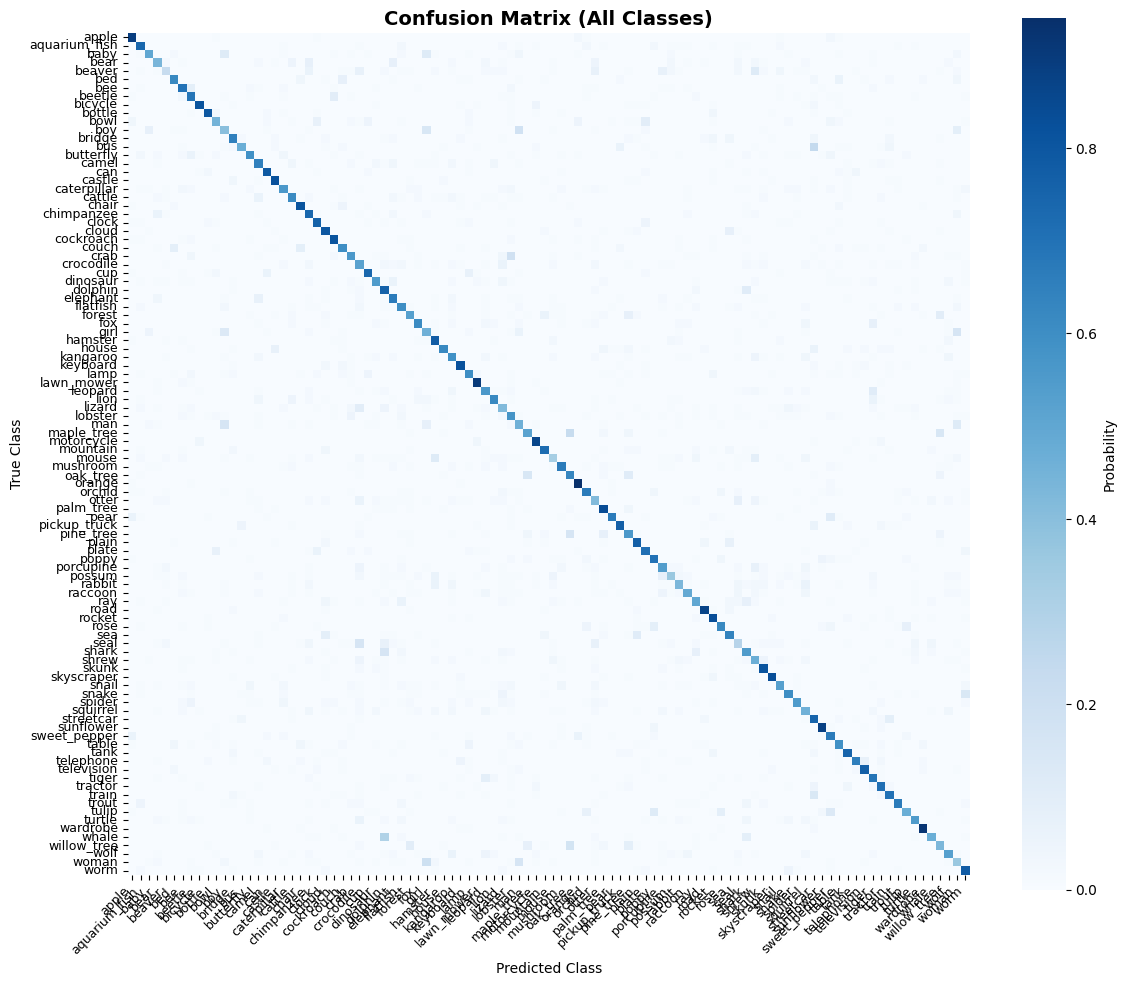


📸 Creating retrieval examples...


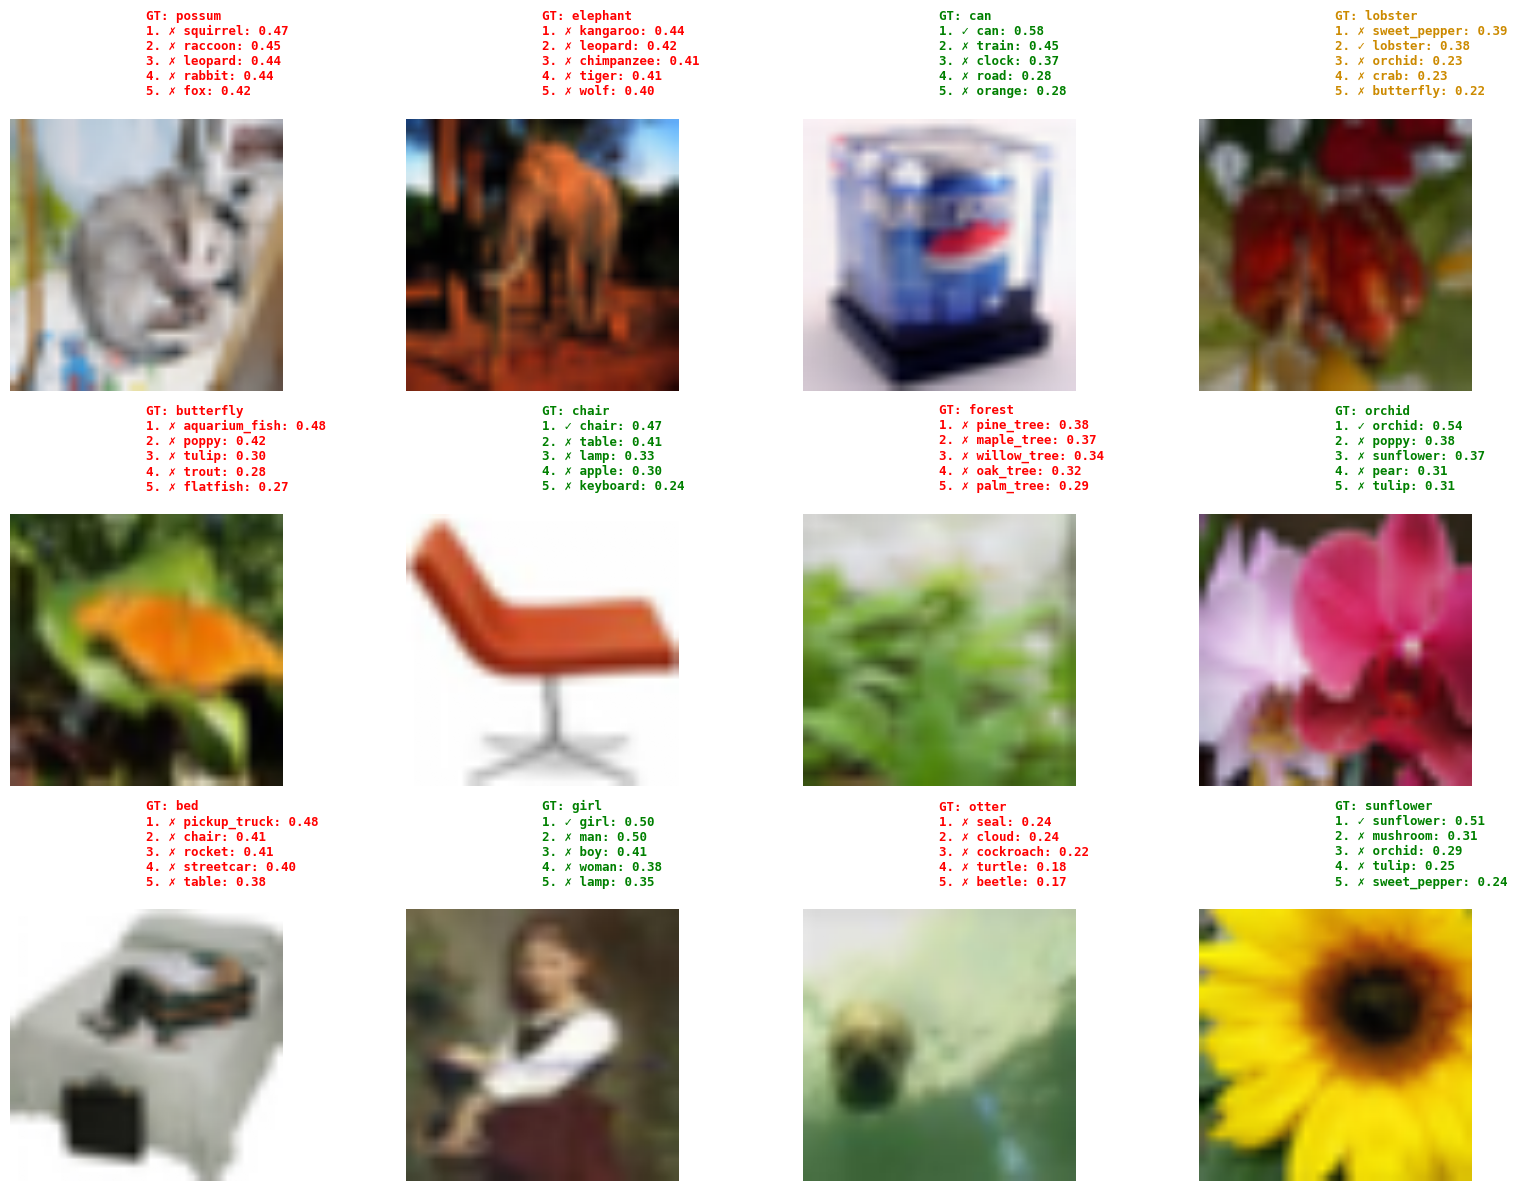


QUALITATIVE EVALUATION

📸 Example Image-to-Text Retrievals:
----------------------------------------------------------------------

Test Image #6463:
  True class: 'bee' (similarity: 0.4889, rank: 1)
  Top 5 predictions:
    1. ✓ bee             (similarity: 0.4889)
    2.   beetle          (similarity: 0.3447)
    3.   rabbit          (similarity: 0.3030)
    4.   caterpillar     (similarity: 0.2960)
    5.   sweet_pepper    (similarity: 0.2681)

Test Image #7427:
  True class: 'leopard' (similarity: 0.3556, rank: 1)
  Top 5 predictions:
    1. ✓ leopard         (similarity: 0.3556)
    2.   shark           (similarity: 0.3463)
    3.   lizard          (similarity: 0.3418)
    4.   snake           (similarity: 0.3068)
    5.   tiger           (similarity: 0.2743)

Test Image #7849:
  True class: 'crab' (similarity: 0.4946, rank: 1)
  Top 5 predictions:
    1. ✓ crab            (similarity: 0.4946)
    2.   lobster         (similarity: 0.3525)
    3.   snail           (similarity: 0.3

In [6]:
# VISUALIZATIONS (using training classes)
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Creates and saves confusion matrix and retrieval examples (plots are shown interactively)
create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx)

# =============================================================================
# QUALITATIVE EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUALITATIVE EVALUATION")
print("="*70)

# Prints text-based examples of image-to-text retrieval for a random sample of test images
print_example_retrievals(sim_matrix, all_labels, class_words, label_to_word)


OUT-OF-DISTRIBUTION IMAGE ANALYSIS

🔬 Using FULL vocabulary (523 words) for OOD predictions
   (Training only learned to separate 100 classes)

  ✓ Downloaded: jellyfish
  ✓ Downloaded: goldfish
  ✓ Downloaded: flamingo
  ✓ Downloaded: pizza
  ✓ Downloaded: strawberry
  ✓ Downloaded: hotdog
  ✓ Downloaded: banana
  ✓ Downloaded: parachute
  ✓ Downloaded: school_bus
  ✓ Downloaded: volcano
  ✓ Downloaded: submarine
  ✓ Downloaded: accordion
  ✓ Downloaded: hourglass
  ✓ Downloaded: revolver
  ✓ Downloaded: dome
  ✓ Downloaded: bobsled

🔬 Processing 16 OOD images...


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2


📸 Creating OOD visualization for 16 images...


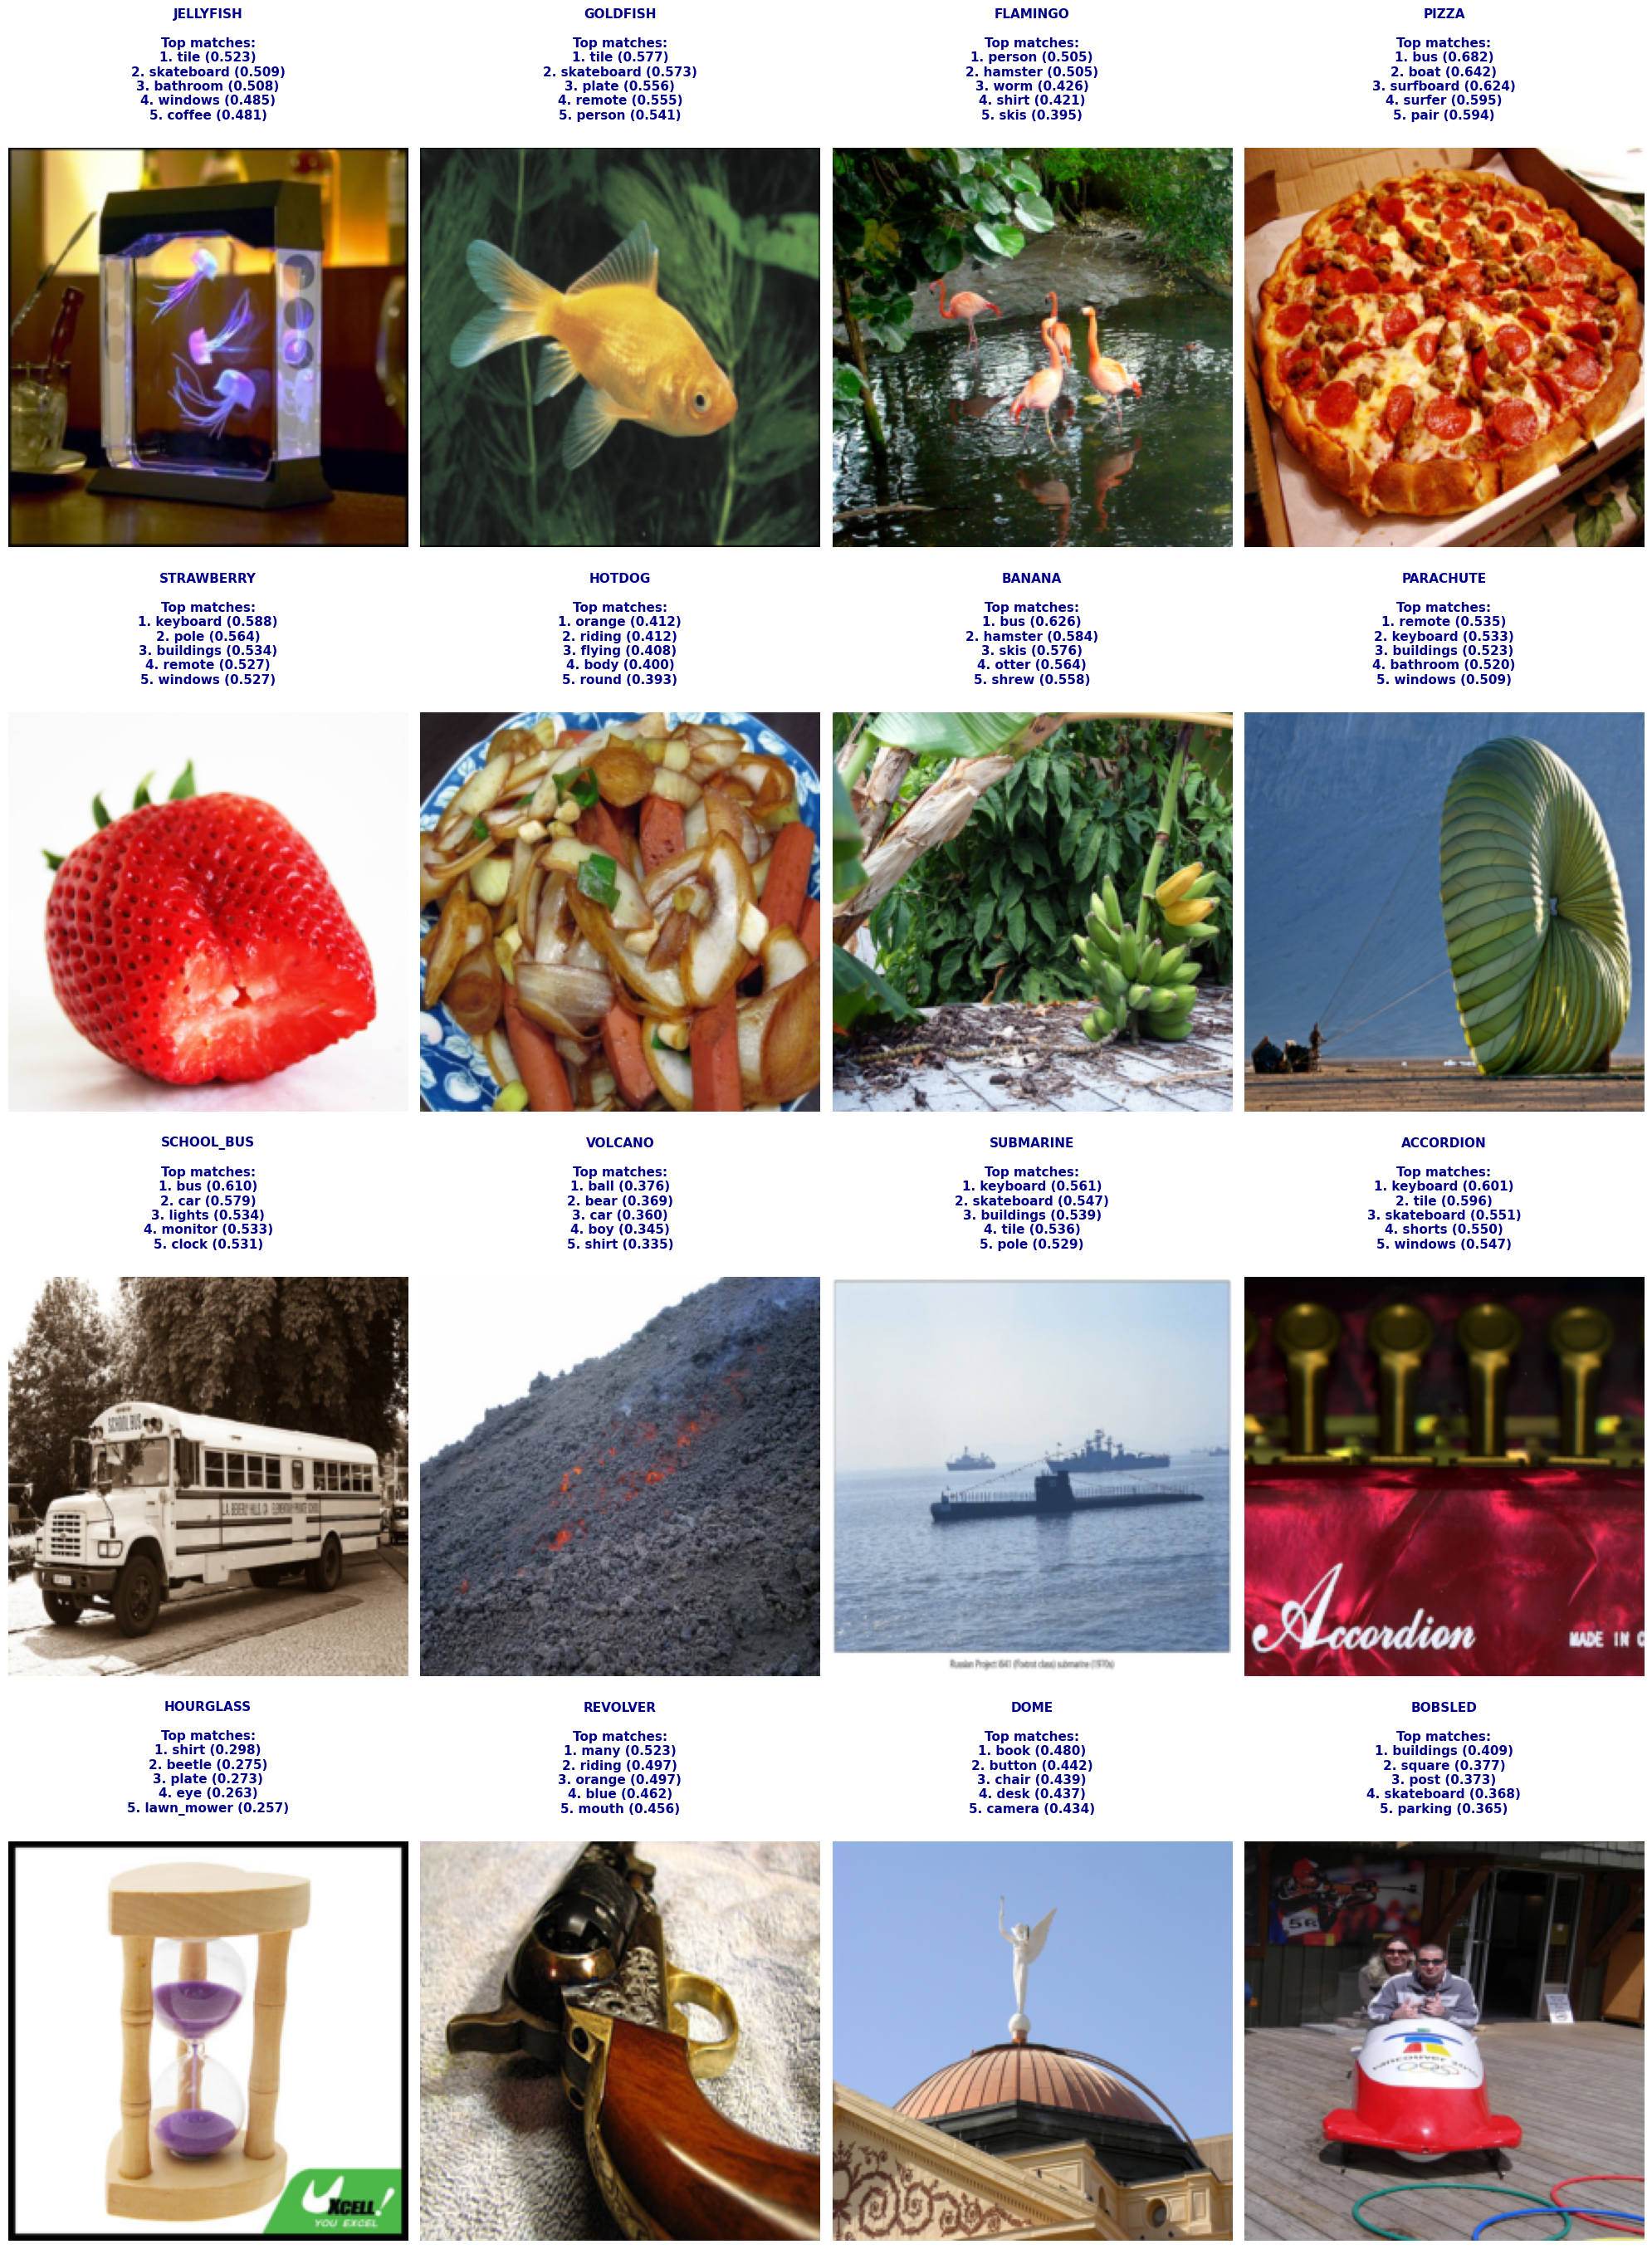

In [7]:
# OOD test images (samples outside of the CIFAR-100 domain)
OOD_URLS = {
    "jellyfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01910747_jellyfish.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "pizza": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07873807_pizza.JPEG",
    "strawberry": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07745940_strawberry.JPEG",
    "hotdog": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07697537_hotdog.JPEG",
    "banana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07753592_banana.JPEG",
    "parachute": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03888257_parachute.JPEG",
    "school_bus": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04146614_school_bus.JPEG",
    "volcano": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n09472597_volcano.JPEG",
    "submarine": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04347754_submarine.JPEG",
    "accordion": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02672831_accordion.JPEG",
    "hourglass": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03544143_hourglass.JPEG",
    "revolver": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04086273_revolver.JPEG",
    "dome": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03220513_dome.JPEG",
    "bobsled": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02860847_bobsled.JPEG",
}

# =============================================================================
# OOD IMAGE ANALYSIS (using ALL vocabulary words)
# =============================================================================
print("\n" + "="*70)
print("OUT-OF-DISTRIBUTION IMAGE ANALYSIS")
print("="*70)

print(f"\n🔬 Using FULL vocabulary ({len(all_vocab_words):,} words) for OOD predictions")
print(f"   (Training only learned to separate {len(class_words)} classes)")

# This function processes the OOD images and calculates predictions against the full vocabulary.
# all_text_emb was prepared in STAGE 4 and contains embeddings for all {vocab_size} VG words.
ood_images, ood_names, ood_predictions = process_ood_images(
    vision_model, OOD_URLS, all_text_emb.cpu().numpy(), all_vocab_words, device
)

# If any images were successfully downloaded and processed, generate a visualization.
if len(ood_images) > 0:
    # The visualization function is reused, but now receives the OOD data
    # (images, names, predictions) to create a dedicated analysis plot.
    create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx,
                         ood_images, ood_names, ood_predictions)

In [8]:
# FINAL REPORT
# =============================================================================
# The final report function gathers all collected metrics and parameters
# (from TRAIN_CONFIG, test results, retrieval metrics, and OOD analysis)
# to print a comprehensive, structured summary.

print_final_report(
    NEW_TRAIN_CONFIG, test_loss, test_sim, i2t_recalls, t2i_recalls, class_stats,
    len(train_idx), len(val_idx), len(test_idx), len(class_words),
    NEW_TRAIN_CONFIG['batch_sizes']['train'], len(ood_images) > 0,
    history, best_epoch, best_val_sim, best_val_loss, len(all_vocab_words)
    )


📋 Training Configuration:
   ├─ Model: MobileNetV3-Small with projection head
   ├─ Embedding dimension: 32
   ├─ Training samples: 40,000, Validation samples: 10,000, Test samples: 10,000
   ├─ Number of training classes: 100
   ├─ Total vocabulary size: 523 words
   ├─ Total epochs trained: 24, Best epoch: 24
   └─ Early stopping patience: 10

🎯 Performance Metrics:
   ├─ Best Val Similarity: 0.4233
   ├─ Test Similarity: 0.4255, Test Loss: 1.7581
   ├─ Random baseline loss: ~6.93
   │
   ├─ Image→Text Recall@1: 63.37%
   ├─ Image→Text Recall@5: 82.07%
   ├─ Image→Text Recall@10: 87.39%
   │
   ├─ Text→Image Recall@1: 62.00%
   ├─ Text→Image Recall@5: 96.00%
   └─ Text→Image Recall@10: 100.00%

📊 Embedding Space Alignment:
   ├─ Mean per-class similarity: 0.4255 ± 0.0617
   ├─ Best aligned class: 'bicycle' (0.6079)
   └─ Worst aligned class: 'mouse' (0.2147)

💡 Key Insights:
   • The model attempts to learn visual-text alignment
   • Low overall alignment (similarity: 0.4255)
   • L

In [9]:
import torch

checkpoint = torch.load('best_clip_vision_model.pth', map_location='cpu')
print(checkpoint.keys())  # See what's saved

# If it has 'model_state_dict':
state_dict = checkpoint['model_state_dict']
for name, param in state_dict.items():
    print(f"{name}: {param.shape}")


FileNotFoundError: [Errno 2] No such file or directory: 'best_clip_vision_model.pth'

In [ ]:
import torch
checkpoint = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
print('Keys:', list(checkpoint.keys()))
for key in checkpoint.keys():
    val = checkpoint[key]
    if hasattr(val, 'shape'):
        print(f'{key}: shape = {val.shape}')
    elif isinstance(val, list):
        print(f'{key}: list of {len(val)} items, first 5: {val[:5]}')
    else:
        print(f'{key}: {type(val).__name__}')

Keys: ['model_state_dict', 'nodes', 'vocab_size', 'embedding_dim']
model_state_dict: OrderedDict
nodes: list of 523 items, first 5: ['a', 'the', 'on', 'of', 'is']
vocab_size: int
embedding_dim: int


----------------------------------
# **COMPARING ALL MODELS**

In [ ]:
V2_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.2,          # ← Higher than v3
    'epochs': 100,
    'patience': 15,              # ← Less patience than v3
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v2.pth',
    
    # Projection head architecture (same as v3)
    'projection_head': [
        ('Linear', 576, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}


checkpoint_v2 = torch.load('new_config_clip_vision_model_v2.pth', map_location='cpu')

print("Model v2 saved stats:")
print(f"  Best epoch: {checkpoint_v2['epoch']}")
print(f"  Val Similarity: {checkpoint_v2['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v2['val_loss']:.4f}")


Model v3 saved stats:
  Best epoch: 18
  Val Similarity: 0.4076
  Val Loss: 1.9270


In [ ]:

# Check saved model stats
import torch

V3_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.1,
    'epochs': 100,
    'patience': 20,
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v3.pth',
    
    # Projection head architecture
    'projection_head': [
        ('Linear', 576, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}

checkpoint_v3 = torch.load('new_config_clip_vision_model_v3.pth', map_location='cpu')

print("Model v3 saved stats:")
print(f"  Best epoch: {checkpoint_v3['epoch']}")
print(f"  Val Similarity: {checkpoint_v3['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v3['val_loss']:.4f}")

Model v3 saved stats:
  Best epoch: 23
  Val Similarity: 0.4446
  Val Loss: 2.9898


In [ ]:
v4_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.07,         # ← CLIP's temperature
    'epochs': 100,
    'patience': 20,
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v4.pth',
    
    # Projection head architecture
    'projection_head': [
        ('Linear', 576, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}

checkpoint_v4 = torch.load('new_config_clip_vision_model_v3.pth', map_location='cpu')

print("Model v4 saved stats:")
print(f"  Best epoch: {checkpoint_v4['epoch']}")
print(f"  Val Similarity: {checkpoint_v4['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v4['val_loss']:.4f}")

Model v4 saved stats:
  Best epoch: 18
  Val Similarity: 0.4076
  Val Loss: 1.9270


In [ ]:
# NOTE REASSESS v2

# === Setup (if running standalone) ===
# Load text embeddings
checkpoint_text = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
nodes = checkpoint_text['nodes']
embeddings = checkpoint_text['model_state_dict']['center_embeddings.weight'].numpy()
word_to_idx, idx_to_word = create_mappings(nodes)

# Get CIFAR vocab and create mappings
cifar_vocab = get_cifar100_vocabulary()
class_words = [w for w in cifar_vocab if w in word_to_idx]
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Create text embeddings tensor
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

# Create dataloaders
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, {'train': 1024, 'eval': 256})

# === Now load and evaluate v2 ===
checkpoint_v2 = torch.load('new_config_clip_vision_model_v2.pth', map_location=device)

print("=== REASSESSING v2 ===")
print(f"Loaded from epoch: {checkpoint_v2['epoch']}")
print(f"Val Similarity: {checkpoint_v2['val_similarity']:.4f}")

vision_model_v2 = ImageEncoder(proj_dim=32, device=device)
vision_model_v2.load_state_dict(checkpoint_v2['model_state_dict'])
vision_model_v2.eval()

visual_emb_v2, all_labels_v2 = collect_embeddings(vision_model_v2, dataloaders['test'], device)

class_stats_v2, i2t_recalls_v2, t2i_recalls_v2, sim_matrix_v2 = compute_alignment_metrics(
    visual_emb_v2, all_labels_v2, training_text_emb.cpu().numpy(), class_words, label_to_word
)

print_analysis_results(class_stats_v2, i2t_recalls_v2, t2i_recalls_v2, len(all_labels_v2), len(class_words))


Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes


/var/folders/9m/37dg7j617sq6gzsrv3mv9hc40000gn/T/ipykernel_20348/795656295.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  training_text_emb = torch.tensor(


=== REASSESSING v2 ===
Loaded from epoch: 23
Val Similarity: 0.4446


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. motorcycle      | Mean: 0.5626 ± 0.0992
 2. oak_tree        | Mean: 0.5549 ± 0.0691
 3. bicycle         | Mean: 0.5354 ± 0.1724
 4. keyboard        | Mean: 0.5339 ± 0.1584
 5. sunflower       | Mean: 0.5249 ± 0.0955
 6. wardrobe        | Mean: 0.5214 ± 0.1474
 7. chair           | Mean: 0.5195 ± 0.1670
 8. poppy           | Mean: 0.5180 ± 0.1525
 9. sweet_pepper    | Mean: 0.5133 ± 0.1407
10. cup             | Mean: 0.5098 ± 0.1429

Bottom 10 Worst Aligned Classes:
 1. flatfish        | Mean: 0.3819 ± 0.1679
 2. forest          | Mean: 0.3782 ± 0.1692
 3. castle          | Mean: 0.3770 ± 0.2278
 4. bus             | Mean: 0.3761 ± 0.1777
 5. seal            | Mean: 0.3695 ± 0.1471
 6. couch           | Mean: 0.3525 ± 0.2250
 7. bowl            | Mean: 0.3344 ± 0.1918
 8. ray             | Mean: 0.3184 ± 0.1920
 9. woman           | Mean: 0.2929 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# NOTE REASSESS v3

# === Setup (if running standalone) ===
# Load text embeddings
checkpoint_text = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
nodes = checkpoint_text['nodes']
embeddings = checkpoint_text['model_state_dict']['center_embeddings.weight'].numpy()
word_to_idx, idx_to_word = create_mappings(nodes)

# Get CIFAR vocab and create mappings
cifar_vocab = get_cifar100_vocabulary()
class_words = [w for w in cifar_vocab if w in word_to_idx]
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Create text embeddings tensor
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

# Create dataloaders
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, {'train': 1024, 'eval': 256})

# === Now load and evaluate v3 ===
checkpoint_v3 = torch.load('new_config_clip_vision_model_v3.pth', map_location=device)

print("=== REASSESSING v3 ===")
print(f"Loaded from epoch: {checkpoint_v3['epoch']}")
print(f"Val Similarity: {checkpoint_v3['val_similarity']:.4f}")

vision_model_v3 = ImageEncoder(proj_dim=32, device=device)
vision_model_v3.load_state_dict(checkpoint_v3['model_state_dict'])
vision_model_v3.eval()

visual_emb_v3, all_labels_v3 = collect_embeddings(vision_model_v3, dataloaders['test'], device)

class_stats_v3, i2t_recalls_v3, t2i_recalls_v3, sim_matrix_v3 = compute_alignment_metrics(
    visual_emb_v3, all_labels_v3, training_text_emb.cpu().numpy(), class_words, label_to_word
)

print_analysis_results(class_stats_v3, i2t_recalls_v3, t2i_recalls_v3, len(all_labels_v3), len(class_words))

Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes
=== REASSESSING v3 ===
Loaded from epoch: 18
Val Similarity: 0.4076


RuntimeError: Error(s) in loading state_dict for ImageEncoder:
	Missing key(s) in state_dict: "projection.8.weight", "projection.8.bias", "projection.9.weight", "projection.9.bias", "projection.9.running_mean", "projection.9.running_var", "projection.11.weight", "projection.11.bias". 
	Unexpected key(s) in state_dict: "projection.7.weight", "projection.7.bias". 
	size mismatch for projection.0.weight: copying a param with shape torch.Size([1024, 576]) from checkpoint, the shape in current model is torch.Size([2048, 576]).
	size mismatch for projection.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for projection.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for projection.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for projection.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for projection.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for projection.4.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([1024, 2048]).
	size mismatch for projection.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for projection.5.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for projection.5.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for projection.5.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for projection.5.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).

In [ ]:
# NOTE REASESS v4

# === Setup (if running standalone) ===
# Load text embeddings
checkpoint_text = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
nodes = checkpoint_text['nodes']
embeddings = checkpoint_text['model_state_dict']['center_embeddings.weight'].numpy()
word_to_idx, idx_to_word = create_mappings(nodes)

# Get CIFAR vocab and create mappings
cifar_vocab = get_cifar100_vocabulary()
class_words = [w for w in cifar_vocab if w in word_to_idx]
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Create text embeddings tensor
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

# Create dataloaders
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, {'train': 1024, 'eval': 256})

# === Now load and evaluate v4 ===
checkpoint_v4 = torch.load('new_config_clip_vision_model_v4.pth', map_location=device)

print("=== REASSESSING v4 ===")
print(f"Loaded from epoch: {checkpoint_v4['epoch']}")
print(f"Val Similarity: {checkpoint_v4['val_similarity']:.4f}")

vision_model_v4 = ImageEncoder(proj_dim=32, device=device)
vision_model_v4.load_state_dict(checkpoint_v4['model_state_dict'])
vision_model_v4.eval()

visual_emb_v4, all_labels_v4 = collect_embeddings(vision_model_v4, dataloaders['test'], device)

class_stats_v4, i2t_recalls_v4, t2i_recalls_v4, sim_matrix_v4 = compute_alignment_metrics(
    visual_emb_v4, all_labels_v4, training_text_emb.cpu().numpy(), class_words, label_to_word
)

print_analysis_results(class_stats_v4, i2t_recalls_v4, t2i_recalls_v4, len(all_labels_v4), len(class_words))


Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes
=== REASSESSING v4 ===
Loaded from epoch: 18
Val Similarity: 0.4126


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. bicycle         | Mean: 0.5937 ± 0.1617
 2. bottle          | Mean: 0.5824 ± 0.1860
 3. motorcycle      | Mean: 0.5611 ± 0.1243
 4. keyboard        | Mean: 0.5507 ± 0.1409
 5. orange          | Mean: 0.5409 ± 0.1022
 6. bus             | Mean: 0.5253 ± 0.1432
 7. pickup_truck    | Mean: 0.5192 ± 0.1629
 8. oak_tree        | Mean: 0.5110 ± 0.0863
 9. wardrobe        | Mean: 0.5051 ± 0.1204
10. train           | Mean: 0.4954 ± 0.1437

Bottom 10 Worst Aligned Classes:
 1. flatfish        | Mean: 0.3415 ± 0.1816
 2. possum          | Mean: 0.3379 ± 0.1567
 3. shrew           | Mean: 0.3353 ± 0.1347
 4. shark           | Mean: 0.3310 ± 0.1321
 5. baby            | Mean: 0.3291 ± 0.1740
 6. seal            | Mean: 0.3140 ± 0.1503
 7. rabbit          | Mean: 0.3106 ± 0.1410
 8. ray             | Mean: 0.3090 ± 0.1378
 9. mouse           | Mean: 0.2983 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# =============================================================================
# v5 CONFIGURATION (BEST MODEL)
# =============================================================================

v5_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.07,
    'epochs': 100,
    'patience': 20,
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v5.pth',
    
    # Projection head architecture (LARGE)
    # 576 → 2048 → BN → ReLU → Dropout(0.3)
    #     → 1024 → BN → ReLU → Dropout(0.2)
    #     → 512  → BN → ReLU
    #     → 32
    'projection_head': [
        ('Linear', 576, 2048),
        ('BatchNorm1d', 2048),
        ('ReLU',),
        ('Dropout', 0.3),
        ('Linear', 2048, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}

checkpoint_v5 = torch.load('new_config_clip_vision_model_v5.pth', map_location='cpu')

print("Model v5 saved stats:")
print(f"  Best epoch: {checkpoint_v5['epoch']}")
print(f"  Val Similarity: {checkpoint_v5['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v5['val_loss']:.4f}")

# v5 RESULTS:
# - Val Similarity: 0.4271
# - I→T Recall@1: 65.07%  ← BEST
# - I→T Recall@5: 82.12%
# - I→T Recall@10: 86.79%
# - T→I Recall@1: 49.00%
# - T→I Recall@5: 94.00%
# - T→I Recall@10: 99.00%

Model v5 saved stats:
  Best epoch: 38
  Val Similarity: 0.4199
  Val Loss: 1.7500
